# PyLopsV2: What's New? 

**Author: M. Ravasi**

The aim of this notebook is to showcase the main new features in **PyLops V2**. This notebook is adapted from https://github.com/PyLops/pylops_transform2022/blob/main/PyLops_v2.ipynb and includes additional features that had not been developed at the time of Transform2022.

For more details on how to quickly migrate your PyLops v1.x codes into PyLops v2.x codes please refer to this [document](https://github.com/PyLops/pylops/blob/dev/MIGRATION_V1_V2.md).

We will divide the notebook in two parts:
    
    - general improvements and new features
    - geophysics related improvements and new features
    
Users that are not interested in the geophysical components of PyLops can simply skip the second part of this notebook.

In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import numba
import numpy as np
import numpy.typing as npt
import scipy as sp
import torch
import torch.nn as nn
import devito 
import pylops

from typing import Tuple
from examples.seismic import Model
from examples.seismic import plot_velocity, plot_shotrecord

from pylops import LinearOperator, TorchOperator
from pylops.basicoperators import *
from pylops.optimization.cls_basic import CGLS
from pylops.signalprocessing import *
from pylops.signalprocessing.sliding2d import sliding2d_design
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.waveeqprocessing.twoway import AcousticWave2D
from pylops.utils.describe import describe
from pylops.utils.wavelets import ricker

logger = logging.getLogger()
logger.setLevel(logging.INFO)

np.random.seed(0)
devito.configuration['log-level'] = 'ERROR'

## General

### The new LinearOperator class

The base `LinearOperator` class used as parent class for every operator that we want to develop in PyLops has gone through a major restyling. This does not affect end-users, however developers of PyLops operator should familiarize with it as it greatly simplifies the way we create operators. Moreover, as we will see later, by creating PyLops operator conforming to this new standard we will be able to apply them to Nd arrays (no more `.ravel()` and  `.reshape()` all over the place!)

To showcase the new way of creating Linear operators, we consider a simple shift operator. See https://github.com/PyLops/pylops_transform2022/blob/main/PyLops_v2.ipynb for more details on the objective of such an operator.

In [2]:
def shiftnd(x: npt.NDArray, shift: int, axis: int = -1):
    "Apply non-circular, integer shift to ND-array on a given axis"
    if shift > x.shape[axis] or shift < -x.shape[axis]:
        return np.zeros_like(x)
    x = np.swapaxes(x, axis, -1)  # Relax, original x is unchanged
    pad = np.zeros((*x.shape[:-1], abs(shift)))
    if shift > 0:
        out = np.concatenate((pad, x[..., :-shift]), axis=-1)
    else:
        out = np.concatenate((x[..., -shift:], pad), axis=-1)
    return np.swapaxes(out, axis, -1)

In [3]:
def shiftnd_linear(x: npt.NDArray, shift: float, axis: int = -1):
    "Apply non-circular, fractional shift to ND-array on a given axis"
    shift_floor = int(np.floor(shift))
    w = shift - shift_floor
    return (1 - w) * shiftnd(x, shift_floor, axis) + w * shiftnd(
        x, shift_floor + 1, axis
    )

In [4]:
class LinearShift(pylops.LinearOperator):
    """LinearShift shifts an N-dimensional array by a single real value along a given axis.

    Since we are responsible coders, this is the entirety of our very long
    and detailed documentation for this class. At least we're annotating...
    """

    def __init__(
        self,
        shift: float,
        dims: Tuple[int, ...],
        axis: int = -1,
        dtype: npt.DTypeLike = np.float32,
        name: str = "L",  # Not required but good practice since v2.0.0
    ):
        # We need to store these variables for computing the shifts
        self.shift = shift
        self.axis = axis

        # Every operator needs a dtype and a shape. Since v2.0.0, we can instead give
        # dims (model shape) *and* dimsd (data shape). `self.shape` is automatically
        # calculated as (np.prod(dimsd), np.prod(dims)).
        # In either case, users are highly encourage to use the `super()` method as it
        # will also automatically populate `self.clinear` (defaults to True) and
        # `self.explicit` (defaults to False). 
        # See the latest documentation:
        # https://pylops.readthedocs.io/en/latest/api/generated/pylops.LinearOperator.html
        super().__init__(dtype=dtype, dims=dims, dimsd=dims, name=name)

    def _matvec(self, x: npt.NDArray):
        x = x.reshape(self.dims)
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        y = y.ravel()
        return y

    def _rmatvec(self, y: npt.NDArray):
        y = y.reshape(self.dimsd)
        # negative shift!
        x = shiftnd_linear(y, shift=-self.shift, axis=self.axis)
        x = x.ravel()
        return x

Let's finally take the operator for a spin

In [5]:
# Original array
x = 1.0 + np.arange(9)
x_3d = np.tile(x, (2, 3, 1))

LOp = LinearShift(0.5, dims=x_3d.shape)

shifted = LOp @ x_3d
shifted_back = LOp.T @ shifted

x_3d, shifted, shifted_back

(array([[[1., 2., 3., 4., 5., 6., 7., 8., 9.],
         [1., 2., 3., 4., 5., 6., 7., 8., 9.],
         [1., 2., 3., 4., 5., 6., 7., 8., 9.]],
 
        [[1., 2., 3., 4., 5., 6., 7., 8., 9.],
         [1., 2., 3., 4., 5., 6., 7., 8., 9.],
         [1., 2., 3., 4., 5., 6., 7., 8., 9.]]]),
 array([[[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
         [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
         [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]],
 
        [[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
         [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],
         [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]]]),
 array([[[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
         [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
         [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25]],
 
        [[1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
         [1.  , 2.  , 3.  , 4.  , 5.  , 6.  , 7.  , 8.  , 4.25],
         [1.  , 2.  , 3.  , 4.  , 5.  , 6.

At this point let's print the dimensions of the input and outputs

In [6]:
x_3d.shape, shifted.shape, shifted_back.shape

((2, 3, 9), (2, 3, 9), (2, 3, 9))

Suprised? Well, if you used PyLops v1 before, this is probably a positive surprise!

From v2, PyLops can handle input ND-arrays and return output ND-arrays. Note that this is different from the case where the input has shape `[Op.shape[1], N]`; in this case PyLops dispatches this array to the `.matmat` method. 

For more details, see the `Table of supported multiplication shapes` in https://github.com/PyLops/pylops/blob/dev/MIGRATION_V1_V2.md.

### Dot-test

The dot-test is also slightly changed. More precisely, we allow now two levels of tolerance to be checked:

- `rtol` (previously `tol`): relative tolerance
- `atol` (new!): absolute tolerance

In [7]:
from pylops.utils import dottest

dottest(LOp, verb=True, rtol=1e-10, atol=1e-10, raiseerror=True);

Dot test passed, v^H(Opu)=-1.8444506555541242 - u^H(Op^Hv)=-1.844450655554124


### Describe method

 In the new version, we use the name of the operator to `describe` it. Here are just a few examples, head over to https://github.com/PyLops/pylops_notebooks/blob/master/developement/Describe.ipynb for more fancy examples.

In [8]:
describe(LOp)

L

where: {'L': 'LinearShift'}


In [9]:
describe(LOp.H @ LOp)

Adjoint(L)*L

where: {'L': 'LinearShift'}


In [10]:
AOp = Diagonal(np.arange(54))
describe(AOp @ LOp)

D*L

where: {'D': 'Diagonal', 'L': 'LinearShift'}


### Reshape/Ravel/Reshape/Ravel/...

Back to the `.ravel()/.reshape()` point. 

One of the biggest pain points when using PyLops v1 is the ravel/reshape combo that pollutes your code. In PyLops 2.0, we have introduced some changes to alleviate that. 

As shown earlier, if we don't flatten the input, we can get a non-flattened output:

In [11]:
y = LOp @ x_3d
y.shape

(2, 3, 9)

In version 1.x, this code would error requiring always `x_3d.ravel()` as input, and always outputting a flat array. 

The magic 🪄 here is in the revamped `LinearOperator` class which understands model dimensions (`LOp.dims`) and data dimensions (`LOp.dimsd`). So whereas it still works with flattened arrays, it is now smart enough to reshape internally when needed.

Moreover, it can also "propagate" dims/dimsd across multiple operators, as well as apply to matrices.
Here are some examples:

In [12]:
y = LOp.T @ LOp @ x_3d
print(y.shape)

(2, 3, 9)


And similarly, for multiple right-hand sides (when PyLops dispatches computations to the `matmat` method)

In [13]:
X_3d = np.concatenate((x_3d[..., np.newaxis], x_3d[..., np.newaxis], 
                       x_3d[..., np.newaxis], x_3d[..., np.newaxis]), axis=-1)
X_3d.shape

(2, 3, 9, 4)

In [14]:
y = LOp.T @ LOp @ X_3d
print(y.shape)

(2, 3, 9, 4)


The class needs no change, as long as it has a nontrivial `dims`/`dimsd`, it will work out of the box. We also included some goodies when implementing new operators. The following pattern is very common:

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        y = kernel_which_operates_on_reshaped(x)
        y = y.ravel()
```

In fact, the following pattern is even more common:

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        x = x.swapaxes(self.axis, -1)
        y = kernel_which_operates_on_reshaped(x)
        y.swapaxes(self.axis, -1)
        y = y.ravel()
```

The swapaxes is often used so that we can always assume that the axis on which to apply an operation is always the last one.
This creates allows us to use the `ellipsis` operator in a smart way: we always operate on `x[..., i]`, instead of having to construct indexers.
Previously, we used to do thing like this 🤢:

```python
i_ndim = [ slice(None) ] * len(self.dims)
i_ndim[self.axis] = i
x[i_ndim]
```


Swapaxes is also super cheap since it returns a view of the array.

Using our new `reshaped` decorator, we can simplify our LinearShift functions from this:

```python
    def _matvec(self, x: npt.NDArray[np.float32]):
        x = x.reshape(self.dims)
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        y = y.ravel()
        return y
```

to this:
    
```python
    from pylops.utils.decorators import reshaped
                     ⋮
    @reshaped
    def _matvec(self, x: npt.NDArray[np.float32]):
        y = shiftnd_linear(x, shift=self.shift, axis=self.axis)
        return y
```

or even this:

```python
    from pylops.utils.decorators import reshaped
                     ⋮
    @reshaped(swapaxis=True)
    def _matvec(self, x: npt.NDArray[np.float32]):
        y = shiftnd_linear(x, shift=self.shift, axis=-1)
        return y
```



### TorchOperator

PyLops's interoperability with other scientific frameworks is one of our top priorities. 

And yes, being able to use PyLops operator directly in PyTorch is a must-have feature. Up until now, this has been possible by using the `TorchOperator` object in the sister library ``pylops-gpu`` (https://github.com/PyLops/pylops-gpu).

We have however come to terms with the fact that having `TorchOperator` directly within PyLops is something many users wanted to. So from now on, simply change from `pylops_gpu.torchoperator import TorchOperator` into `from pylops.torchoperator import TorchOperator`.

Here is a simple example of its full potential

In [15]:
class Network(nn.Module):
    def __init__(self, input_channels):
        super(Network, self).__init__()
        self.conv = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

In [16]:
net = Network(2)

In [17]:
# Single sample batch
n = 16
Top = Transpose(dims=(n, n), axes=(1,0))
Top_torch = TorchOperator(Top, device='cpu')

# forward
x = torch.ones((1, 2, n, n)).requires_grad_(True)
y = Top_torch.apply(net(x).view(-1)) # dry run
print(y.shape)

# backward
y = Top_torch.apply(net(x).view(-1))
loss = y.sum()
loss.backward()
print(x.grad.shape)

torch.Size([256])
torch.Size([1, 2, 16, 16])


[W NNPACK.cpp:80] Could not initialize NNPACK! Reason: Unsupported hardware.


In [18]:
# Multiple samples batch
n = 16
Top = Transpose(dims=(n, n), axes=(1,0))
Top_torch = TorchOperator(Top, device='cpu', batch=True)

# forward
x = torch.ones((2, 2, n, n)).requires_grad_(True)
y = Top_torch.apply(net(x).reshape(2,n*n)) # dry run
print(y.shape)

# backward
y = Top_torch.apply(net(x).reshape(2,n*n))
loss = y.sum()
loss.backward()
print(x.grad.shape)

torch.Size([2, 256])
torch.Size([2, 2, 16, 16])


### Sliding/Patching design

PyLops v1 shipped with a number of sliding/patching operators. Whilst very useful in principle, these operators were difficult to use because of:

- the need to `.ravel()` input vectors made it difficult for user to reconstruct the correct dimensions and extract patches
- the design of the operator was directly linked with the initialization phase of the operator itself (via the `design` optional argument). This led users to either run the operator once in interactive mode to find out the correct number of windows or to guess upfront (when running codes in batch mode).

We have already discussed how the first problem is seamlessly solved with the new design of `LinearOperator` in v2. To solve the second problem, we have decided to provide auxiliary routines to be run prior to instantiating the operator that provide the correct number of windows to be used.

Here is an example with `Sliding2D`. For more examples, see https://github.com/PyLops/pylops_notebooks/blob/master/developement/Patching.ipynb

In [19]:
# Create dataset with parabolic events
par = {'ox':-140, 'dx':2, 'nx':136,
       'ot':0, 'dt':0.004, 'nt':150,
       'f0': 30}

v = 1500
t0 = [0.2, 0.4, 0.5]
px = [0, 0, 0]
pxx = [1e-5, 5e-6, 1e-20]
amp = [1., -2, 0.5]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate data
_, data = pylops.utils.seismicevents.parabolic2d(x, t, t0, px,
                                                 pxx, amp, wav)
#data = data[:, 60:]
#pad = 12
#data = np.pad(data, ((pad, pad), (pad, pad)), mode='edge')

In [20]:
dimsd = data.shape
nwin = 26
nover = 4

Op = FFT2D((nwin, dimsd[1]), nffts=(256, 256), real=True)

nwins, dims, mwin_inends, dwin_inends = sliding2d_design(dimsd, nwin, nover, (256, 129))
Sop = Sliding2D(Op.H, dims, dimsd, nwin, nover,
                tapertype=None)

patches = Sop.H * data

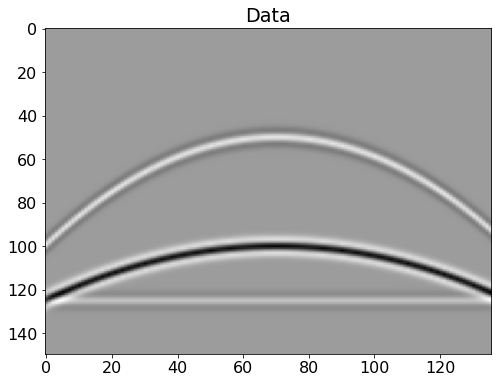

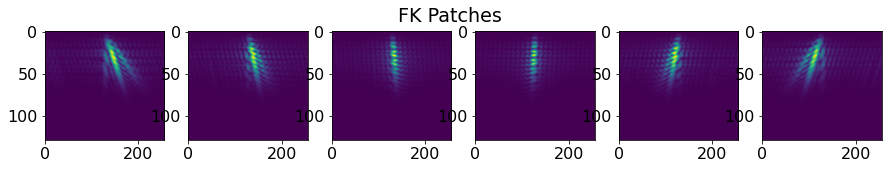

In [21]:
plt.figure()
plt.imshow(data.T, cmap='gray')
plt.title('Data')
plt.axis('tight')

fig, axs = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    axs[i].imshow(np.fft.fftshift(np.abs(patches[i]).T, axes=1))
    axs[i].axis('tight')
fig.suptitle('FK Patches', y=1.05);

### Class-based solvers

PyLops v1 provides a variety of solvers (e.g., basic, least-squares, sparsity). These solvers are function-based, in the sense that a user passes the operator, data, and other additional parameters to a function, and the solution is returned (alongside other output parameters).

Whilst easy to use, such solvers are quite still and cannot be customized: at best, a user can pass a callback function to be run after every iteration.

In PyLops v2 we have restructured all solvers to become class-based: a user can instantiate a solver and run it step by step. 

Finally, note that uUers willing to use function-based solvers can keep doing so as we have also wrapped the new class-based solvers into functions that have the same look and feeling of solvers in v1.

Let's see an example, for more example we refer to https://github.com/PyLops/pylops_notebooks/blob/master/developement/SolverClass.ipynb.

In [22]:
ny, nx = 100, 50
x = np.ones(nx)
A = np.random.normal(0, 1, (ny, nx))
Aop = pylops.MatrixMult(A)
y = A @ x

CGLS
-----------------------------------------------------------------
The Operator Op has 100 rows and 50 cols
damp = 0.000000e+00	tol = 0.000000e+00	
-----------------------------------------------------------------

    Itn          x[0]              r1norm         r2norm
     1        1.1779e+00         2.9817e+01     2.9817e+01
    11        9.9186e-01         3.9399e-01     3.9399e-01
    21        1.0000e+00         1.9202e-03     1.9202e-03
    31        1.0000e+00         1.1565e-05     1.1565e-05
    41        1.0000e+00         7.2812e-09     7.2812e-09
    51        1.0000e+00         2.1143e-12     2.1143e-12
    61        1.0000e+00         1.1206e-14     1.1206e-14
    71        1.0000e+00         1.1206e-14     1.1206e-14
    81        1.0000e+00         1.1206e-14     1.1206e-14
    91        1.0000e+00         1.1206e-14     1.1206e-14

Iterations = 100        Total time (s) = 0.01
-----------------------------------------------------------------



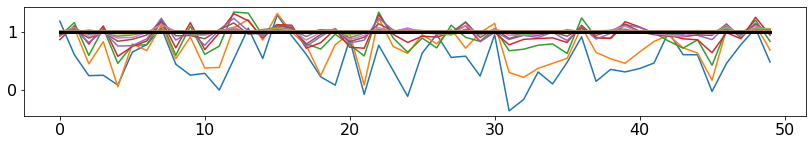

In [23]:
def callback(xx, xhist):
    xhist.append(xx.copy())
    
cgsolve = CGLS(Aop)

xhist = []
cgsolve.callback = lambda x: callback(x, xhist)

x = cgsolve.setup(y=y, x0=np.zeros(nx), tol=0, show=True)
for i in range(ny):
    x = cgsolve.step(x, True if i % 10 == 0 else False)
    cgsolve.callback(x)
cgsolve.finalize(True)
xest = x.copy()

plt.figure(figsize=(14, 2))
plt.plot(np.vstack(xhist).T)
plt.plot(xest, 'k', lw=3);

## Geophysics

### Kirchhoff and AcousticWave2D operators

The ``pylops.waveeqprocessing.lsm.Demigration`` and ``pylops.waveeqprocessing.lsm.LSM`` classes in PyLops v1 used to provide basic functionalities for Kirchhoff-based modelling and inversion of the acoustic wave equations. 

This module has been greatly revamped and contains now only the ``pylops.waveeqprocessing.lsm.LSM`` class; more importantly, this class is now designed not only to invert acoustic data using an Kirchhoff-based modelling but also using a two-way wave equation-based modelling engine. 

The former, Kirchhoff-based modelling, is now placed in ``pylops.waveeqprocessing.Kirchhoff``. The latter, two-way wave equation-based modelling, is placed in ``pylops.waveeqprocessing.AcousticWave2D``.

In the following we will look at these two new operators and learn how to initialize them and use them to create data. For more detailed modelling (and inversion examples), we refer you to the different `LeastSquares*.ipynb` notebooks.

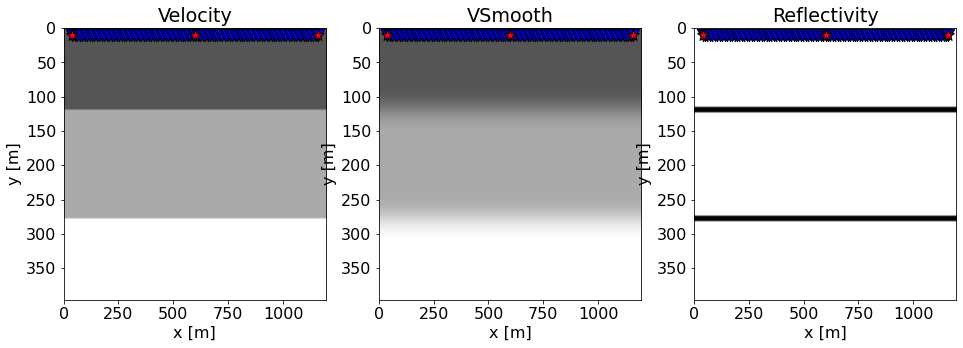

In [24]:
# Velocity Model
nx, nz = 300, 100
dx, dz = 4, 4
x, z = np.arange(nx)*dx, np.arange(nz)*dz

v0 = 1500 # initial velocity
vel = v0 * np.ones((nx, nz))
vel[:, 30] = 1800
vel[:, 30:70] = 2000
vel[:, 70:] = 2500

# Smooth velocity
vsmooth = sp.signal.filtfilt(np.ones(9)/9, 1, vel, axis=1)

# Reflectivity Model
DOp = FirstDerivative((nx, nz), axis=1)
refl = DOp * vel

# Receivers
nr = 101
rx = np.linspace(10*dx, (nx-10)*dx, nr)
rz = 10*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 3
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

# Wavelet
nt = 201
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(vel.T, cmap='gray', vmin=1000, vmax=2500, extent=(x[0], x[-1], z[-1], z[0]))
axs[0].scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
axs[0].scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]'),axs[0].set_ylabel('y [m]')
axs[0].set_title('Velocity')
axs[0].set_xlim(x[0], x[-1])

axs[1].imshow(vsmooth.T, cmap='gray', vmin=1000, vmax=2500, extent = (x[0], x[-1], z[-1], z[0]))
axs[1].scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
axs[1].scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]'),axs[1].set_ylabel('y [m]')
axs[1].set_title('VSmooth')
axs[1].set_xlim(x[0], x[-1])

axs[2].imshow(refl.T, cmap='gray_r', extent = (x[0], x[-1], z[-1], z[0]))
axs[2].scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
axs[2].scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]'),axs[2].set_ylabel('y [m]')
axs[2].set_title('Reflectivity')
axs[2].set_xlim(x[0], x[-1]);

In [25]:
# Kirchoff modelling
kirch1 = Kirchhoff(z, x, t, sources, recs, v0, wav, wavc, dynamic=True, 
                   mode='eikonal', engine='numba', aperture=2, angleaperture=30)

# Data
dk = kirch1 * refl.ravel()
dk = dk.reshape(ns, nr, nt)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
axs[0].imshow(dk[0, :, :300].T, cmap='gray')
axs[0].set_title(r'$d_1$')
axs[0].axis('tight')
axs[1].imshow(dk[1, :, :300].T, cmap='gray')
axs[1].set_title(r'$d_2$')
axs[1].axis('tight')
axs[2].imshow(dk[2, :, :300].T, cmap='gray')
axs[2].set_title(r'$d_3$')
axs[2].axis('tight');

TypeError: __init__() got an unexpected keyword argument 'dynamic'

INFO: recompiling for non-existent cache dir (/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/devito-codepy-uid859365970/487366a/308402af5eeb67375ab3581953abb944).
INFO: recompiling for non-existent cache dir (/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/devito-codepy-uid859365970/abc485e/8a211831f79b595ad89e11b9b5c63e16).
INFO: recompiling for non-existent cache dir (/var/folders/pc/wf4mhn4n2cv8wjt_jtj8t8qhsljrkk/T/devito-codepy-uid859365970/b619b12/8d4121e11fd7540d28f9fa781c2f4b32).


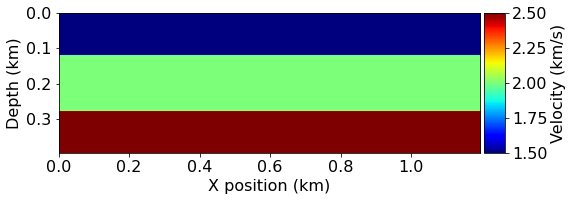

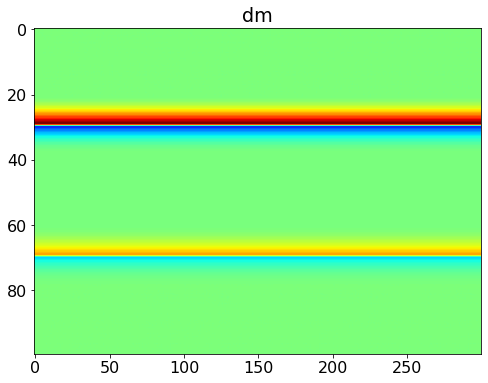

In [26]:
# Two-way modelling
Aop = AcousticWave2D((nx, nz), (0,0), (dx, dz), vel,
                     sx, sz[0], rx, rz[0], 0., t[-1]*1e3, 'Ricker',
                     space_order=4, nbl=50, f0=20,
                     dtype="float32")

# Born perturbation from m - m0
dm = ((vel/1000)**(-2) - (vsmooth/1000)**(-2))

# Data
dtw = Aop @ dm

# Display
plot_velocity(Aop.model)

plt.figure()
plt.imshow(dm.T, cmap='jet', vmin=-1e-1, vmax=1e-1)
plt.title('dm')
plt.axis('tight');

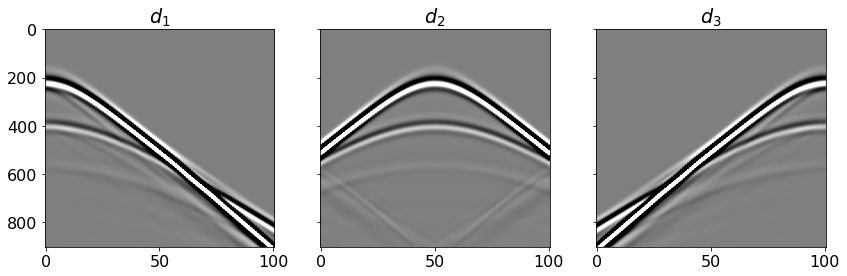

In [27]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 4))
axs[0].imshow(dtw[0].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title(r'$d_1$')
axs[0].axis('tight')
axs[1].imshow(dtw[1].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title(r'$d_2$')
axs[1].axis('tight')
axs[2].imshow(dtw[2].reshape(Aop.geometry.nrec, Aop.geometry.nt).T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title(r'$d_3$')
axs[2].axis('tight');